# Logistic Regression (Classification)

So far we have been looking at regression problems, where the solution are continous variables. Let us look at a binary classification problem - where we need to identify the correct class [0 or 1]

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
pop = pd.read_csv('data/cars_small.csv')

In [4]:
pop.head()

,brand,model,price,kmpl,bhp,type
0,Chevrolet,Beat,421,18.6,79,Hatchback
1,Chevrolet,Sail,551,18.2,82,Sedan
2,Chevrolet,Sail Hatchback,468,18.2,82,Hatchback
3,Chevrolet,Spark,345,16.2,62,Hatchback
4,Fiat,Linea Classic,612,14.9,89,Sedan


Lets say we want to classify the vehicles by 'Hatchback' and 'Sedan'

In [5]:
class_mapping = {'Hatchback': 0, 'Sedan': 1}

In [6]:
pop['types'] = pop['type'].map(class_mapping)

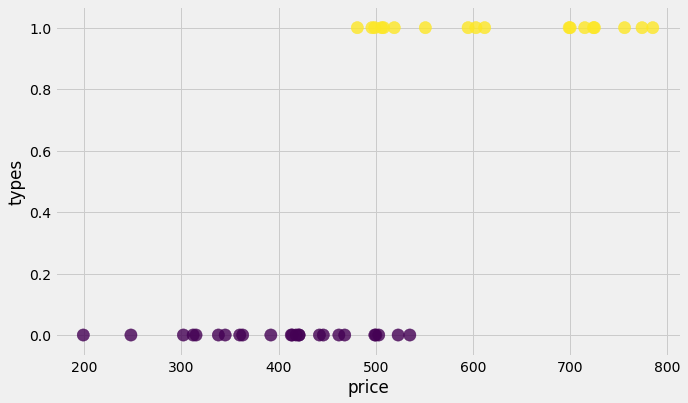

In [7]:
plt.scatter(pop.price, pop.types, c=pop.types, s = 150, alpha = 0.8 )
plt.xlabel('price')
plt.ylabel('types')

## Why Linear Function does not work
Now we can use a linear function and try to choose a cutoff value to show where the two class separate - lets say cutoff = 0.5

In [8]:
def ols (df, xlabel, ylabel):
    n = df.shape[0]
    x0 = np.ones(n)
    x1 = df[xlabel]
    X = np.c_[x0, x1]
    X = np.asmatrix(X)
    y = np.transpose(np.asmatrix(df[ylabel]))
    X_T = np.transpose(X)
    X_pseudo = np.linalg.inv(X_T * X) * X_T
    beta = X_pseudo * y
    return beta

In [9]:
def plot_ols(df, xlabel, ylabel):
    beta = ols(df, 'price', 'types')
    beta_0 = beta.item(0)
    beta_1 = beta.item(1)
    plt.scatter(df[xlabel], df[ylabel], c=df[ylabel], s = 150, alpha = 0.8 )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    y = beta_0 + beta_1 * df[xlabel]
    plt.plot(df[xlabel], y, '-')
    
    cutoff = (0.5 - beta_0)/beta_1
    plt.vlines(cutoff, -0.4, 1.4)

In [10]:
ols(pop, 'price', 'types')

matrix([[-0.85225329],
        [ 0.00257551]])

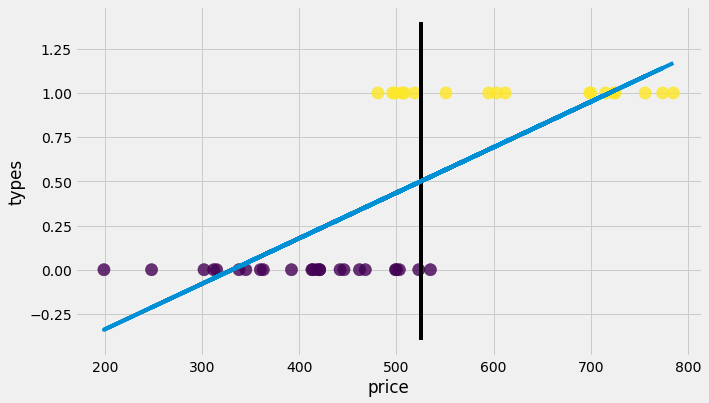

In [11]:
plot_ols(pop, 'price', 'types')

However, there are two problems with this approach
- The cut-off value is highly influenced by outliers
- The value of linear regression is unbounded, while our classification is bounded

In [12]:
pop1 = pop.copy()

In [13]:
pop1.tail()

,brand,model,price,kmpl,bhp,type,types
37,Toyota,Etios,603,16.8,89,Sedan,1
38,Toyota,Etios Liva,500,17.7,79,Hatchback,0
39,Volkswagen,Polo,535,16.5,74,Hatchback,0
40,Volkswagen,Up,360,21.0,74,Hatchback,0
41,Volkswagen,Vento,785,16.1,104,Sedan,1


In [14]:
# Lets create an outlier
pop1.loc[37,'price'] = 1500
pop1.loc[41,'price'] = 2000

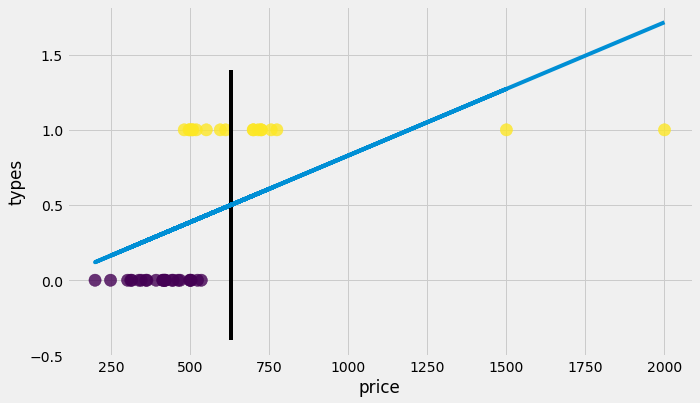

In [15]:
plot_ols(pop1, 'price', 'types')

## Logistic Function

So we need a function which is bounded between 0 < f(X) < 1, for our classification to work. We will use a logit function for this purpose

$$ P(z) = \frac {1}{1 + e^{-z}} $$

In [16]:
z = np.linspace(-10, 10, 100)

In [17]:
p = 1/(1+np.exp(-z))

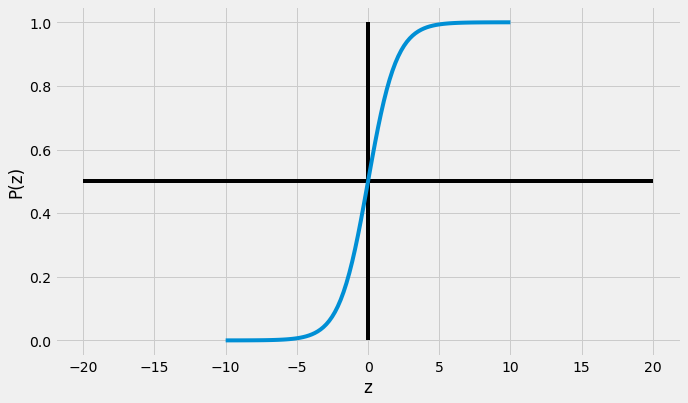

In [18]:
plt.plot(z,p)
plt.hlines(0.5, -20,20)
plt.vlines(0, 0,1)
plt.xlabel('z')
plt.ylabel('P(z)')

So now we can transpose our linear regression problem with this logit function

$$ y = X\beta $$

becomes

$$ P(y) = P(X\beta) $$

$$ y = 0, when \, P(y) >0.5 $$ 
which is equivalent to $$X\beta > 0 $$




Lets see this in the example in 'price' and 'kmpl' variables, for class $types$

$$ \beta_0 + \beta_1*price + \beta_2*kmpl + \epsilon > 0 $$

So we are looking for a line which will fulfill the above condition

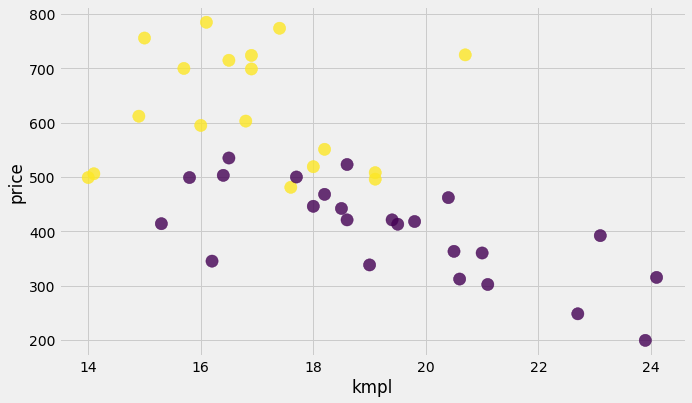

In [19]:
plt.scatter(pop['kmpl'], pop['price'], c=pop['types'], s = 150, alpha = 0.8 )
plt.xlabel('kmpl')
plt.ylabel('price')

## Cost Function 

$$Cost (P(X\beta), y)) = 
\begin{cases}
-log(P(X\beta)),  & \text{if $y=1$ } \\
-log(1 -P(X\beta)), & \text{if $y =0$}
\end{cases}$$

In [20]:
z = np.linspace(0.001, 0.999, 1000)

In [21]:
c1 = -np.log(z)
c2 = -np.log(1-z)

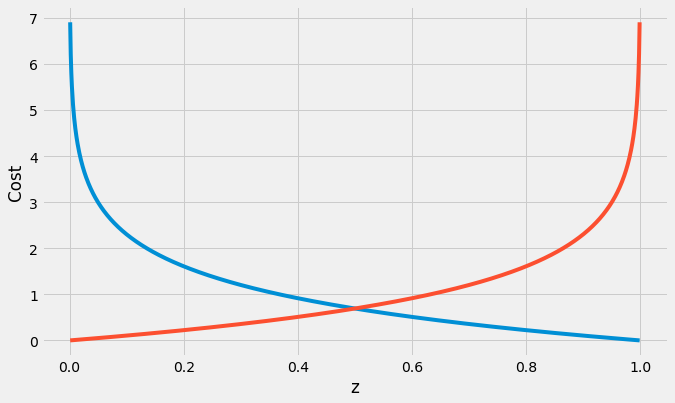

In [22]:
plt.plot(z,c1)
plt.plot(z,c2)
#plt.hlines(0.5, -10,10)
#plt.vlines(0, 0,1)
plt.xlabel('z')
plt.ylabel('Cost')

## Gradient Descent for Logistic Function

To make it easier to work with we can write this in one line - Log-Likelihood Function

$$ C(\beta) = \frac{1}{n} (- y^T * log(P(X\beta)) - (1- y^T) * log(1 -P(X\beta))) $$

If we were to differentiate this, we will get our gradient which is very similiar to our linear regression one:

$$ \nabla C(\beta) =  \frac {2}{n} X^T(P(X\beta)−y) $$

and are gradient descent algorithm will be 

$$ \beta_{i+1} = \beta_{i} - \eta * \nabla C(\beta)$$



In [23]:
n = pop.shape[0]
x0 = np.ones(n)
x1 = pop.kmpl
x2 = pop.price
X_actual = np.c_[x1, x2]

In [24]:
X_norm = (X_actual - np.mean(X_actual, axis=0)) / np.std(X_actual, axis=0)

In [25]:
X = np.c_[x0, X_norm]

In [26]:
X = np.asmatrix(X)
y = np.asmatrix(pop.types.values.reshape(-1,1))
b = np.asmatrix([[0],[0],[0]])

In [27]:
def P(z): 
    return 1.0/(1+np.exp(-z))

In [28]:
def cost(X,y,b,n):
    C = (- y.T*np.log(P(X*b))-(1-y.T)*np.log(1-P(X*b)))/n
    return C[0,0]

In [29]:
def gradient(X,y,b,n):
    g = (2/n)*X.T*(P(X*b) - y)
    return g

In [30]:
def gradient_descent_logistic (eta, epochs, X, y, n):
    
    # Set Initial Values 
    b = np.asmatrix([[0],[0],[0]])
    c = cost(X,y,b,n)
    c_all = []
    c_all.append(c)

    # Run the calculation for those many epochs
    for i in range(epochs):
        g = gradient(X,y,b,n)
        b = b - eta * g
        c = cost(X,y,b,n)
        c_all.append(c)
            
    return c_all, b

In [31]:
from __future__ import division
x1_min, x1_max = -3, 3
x2_min, x2_max = -3, 3
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, (x1_max - x1_min)/100), 
                       np.arange(x2_min, x2_max, (x2_max - x2_min)/100))
xx = np.c_[np.ones(xx1.ravel().shape[0]), xx1.ravel(), xx2.ravel()]

In [32]:
def plot_gradient_descent(eta, epoch, gradient_func):
    
    es, bs = gradient_func(eta, epoch, X, y, n)
    
    # Plot the intercept and coefficients
    plt.subplot(1, 2, 1)
    #plt.tight_layout()
    
    # Plot the probabilty plot contour
    Z = P(xx*bs)
    Z = Z.reshape(xx1.shape)
    cs = plt.contourf(xx1, xx2, Z, cmap=plt.cm.viridis, alpha = 0.5)
    plt.colorbar(cs)
    
    # Plot the intercept and coefficients
    plt.scatter(X[:,1], X[:,2], c=pop.types, s = 150, alpha = 0.8 )
    plt.xlabel('kmpl')
    plt.ylabel('price')
    
    # Plot the error rates
    plt.subplot(1, 2, 2)
    plt.plot(es)
    plt.xlabel('Epochs')
    plt.ylabel('Error')

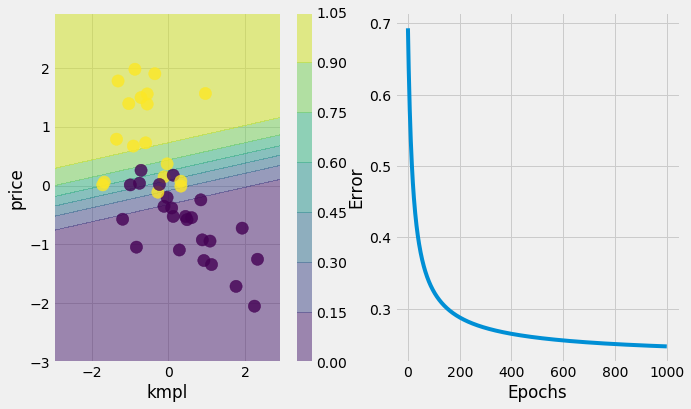

In [33]:
plot_gradient_descent(0.05, 1000, gradient_descent_logistic)